In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/us_election.csv')

In [3]:
data.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,lon,lat
0,1,5,1005,2291820706,50864677,Barbour County,AL,26887,27457,-2.1,...,5873,5539,5,1,0.512523,0.483376,334,0.029147,-85.393211,31.869580
1,1,23,1023,2365954971,19059247,Choctaw County,AL,13323,13858,-3.9,...,3785,4150,23,1,0.475204,0.521030,365,-0.045825,-88.263180,32.019772
2,1,35,1035,2201896058,6643480,Conecuh County,AL,12670,13228,-4.2,...,3551,3434,35,1,0.506345,0.489662,117,0.016683,-86.993674,31.429234
3,1,51,1051,1601876535,99850740,Elmore County,AL,80977,79296,2.1,...,8940,26223,51,1,0.252257,0.739927,17283,-0.487669,-86.149159,32.596647
4,1,65,1065,1667804583,32525874,Hale County,AL,15184,15760,-3.7,...,5401,3205,65,1,0.625985,0.371465,2196,0.254520,-87.629146,32.762664


In [4]:
dem_pct = data['pct_dem_16']

In [5]:
features = data[['PST045214', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
                 'RHI225214', 'RHI325214', 'RHI425214', 'RHI525214', 'RHI725214', 'POP645213',
                 'POP815213', 'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'INC110213',
                 'PVY020213', 'SBO001207', 'RTN131207']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, dem_pct, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.8132854114506937

In [12]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 3)

In [13]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

  0%|          | 0/21 [00:00<?, ?it/s]/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:25:41] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
 38%|███▊      | 8/21 [00:48<01:18,  6.01s/it]/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:25:43] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:25:45] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are no

(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)
(311,)

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:29:07] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/louxiayin/Academy/Research/UncertaintyGeoXAI/GeoConformalizedExplainer/GeoConformalizedExplainer.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature_name}_geo_uncertainty'] = geocp_result.geo_uncertainty
/Users/louxiayin/Academy/Research/UncertaintyGeoXAI/GeoConformalizedExplainer/GeoConformalizedExplainer.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

In [14]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
PST045214,0.909968,0.985765,0.004508,0.001428,0.001391
AGE135214,0.887460,0.851463,0.002159,0.000031,0.000026
AGE295214,0.909968,0.984733,0.004417,0.001278,0.001223
AGE775214,0.913183,0.863914,0.003432,0.000087,0.000079
SEX255214,0.881029,0.927703,0.003276,0.000148,0.000148
RHI125214,0.926045,0.993574,0.005400,0.004538,0.004749
RHI225214,0.932476,0.982396,0.003195,0.000580,0.000568
RHI325214,0.916399,0.881417,0.002409,0.000049,0.000043
RHI425214,0.864952,0.887423,0.004692,0.000196,0.000177
RHI525214,0.906752,0.909799,0.001687,0.000032,0.000022


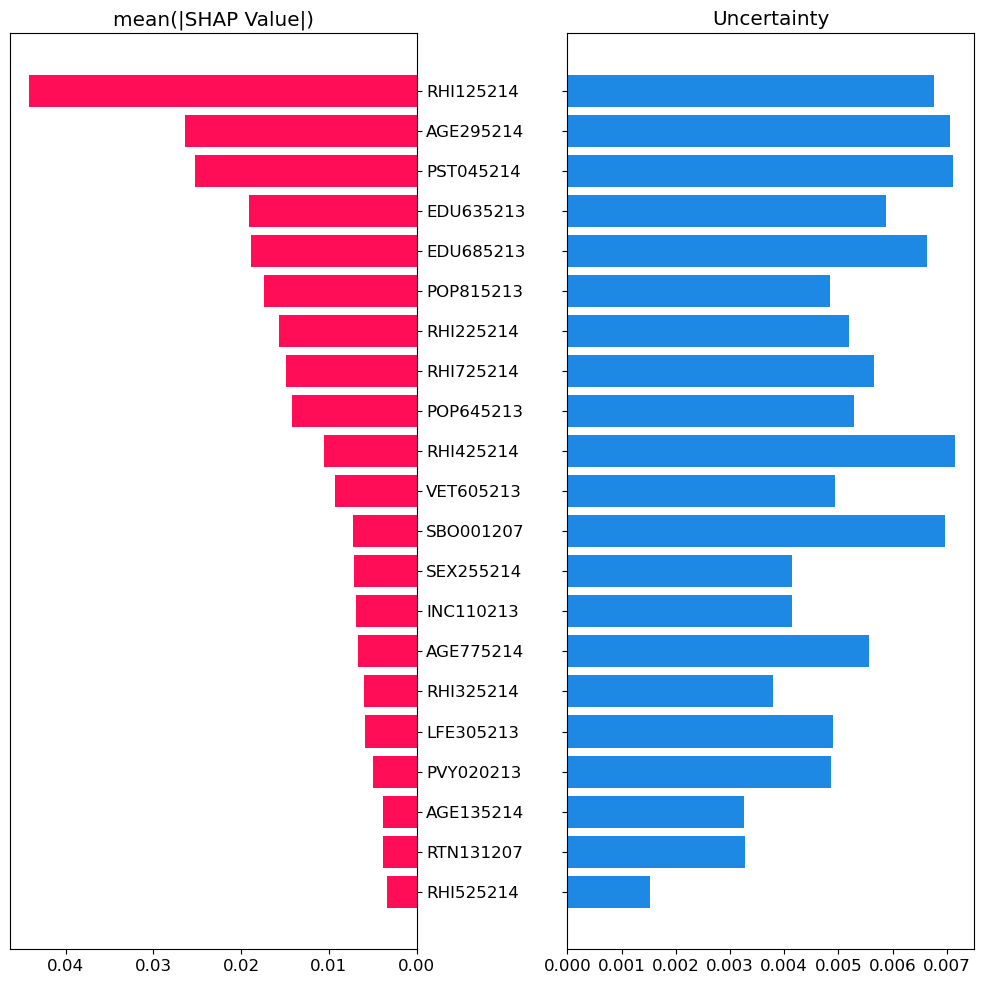

In [15]:
results.plot_absolute_shap_value_with_uncertainty()

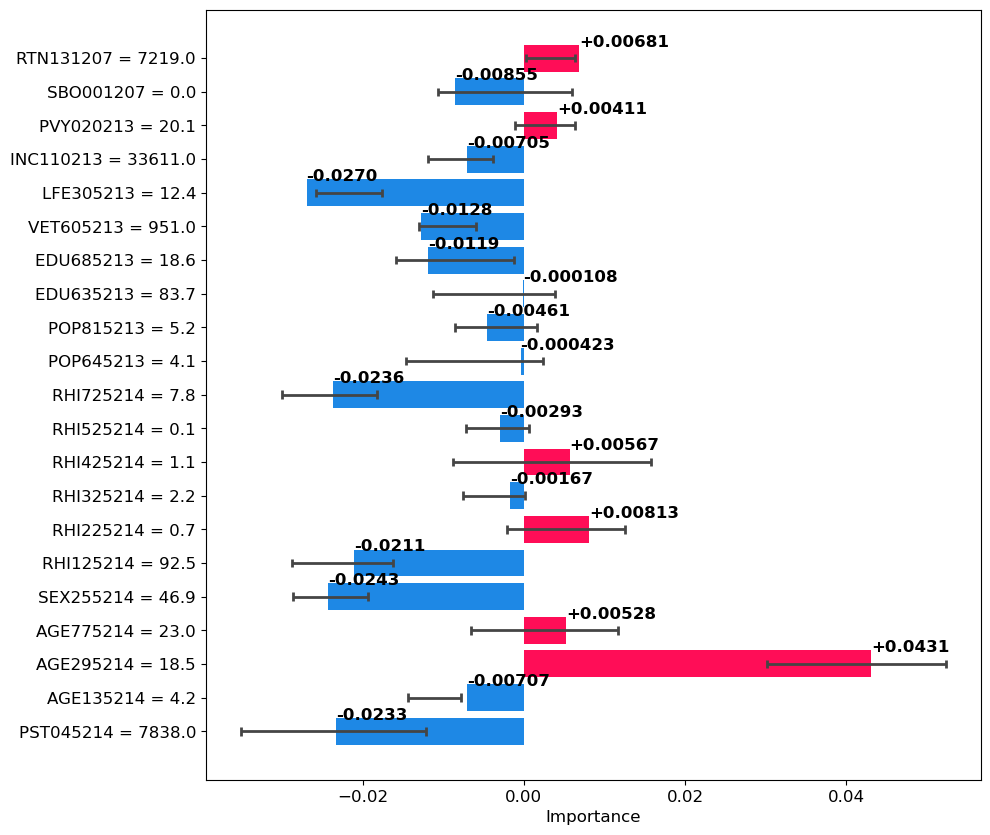

In [16]:
 results.plot_shap_values_with_uncertainty(10)

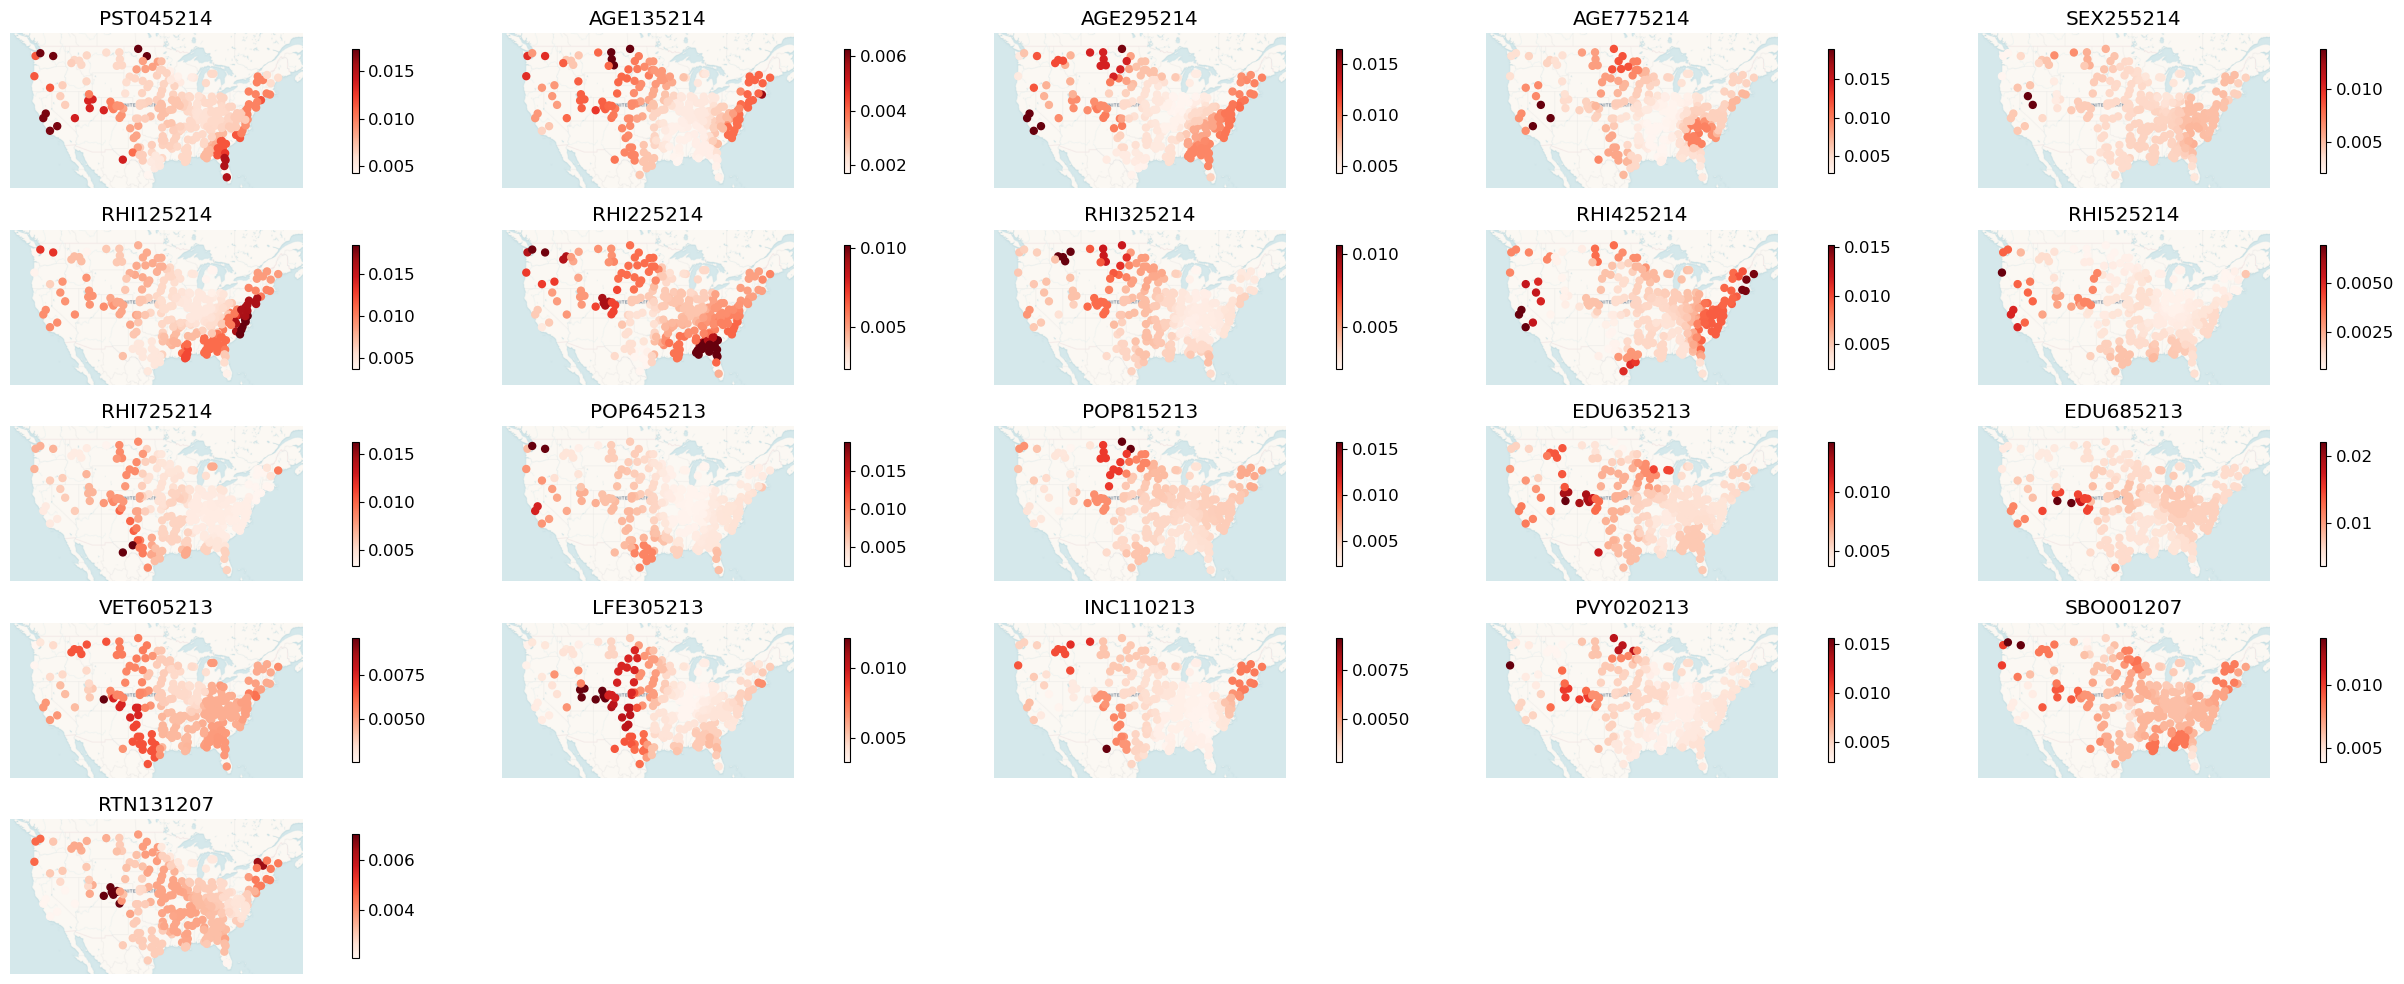

In [17]:
results.plot_geo_uncertainty(figsize=(30, 10), shrink=0.8)

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

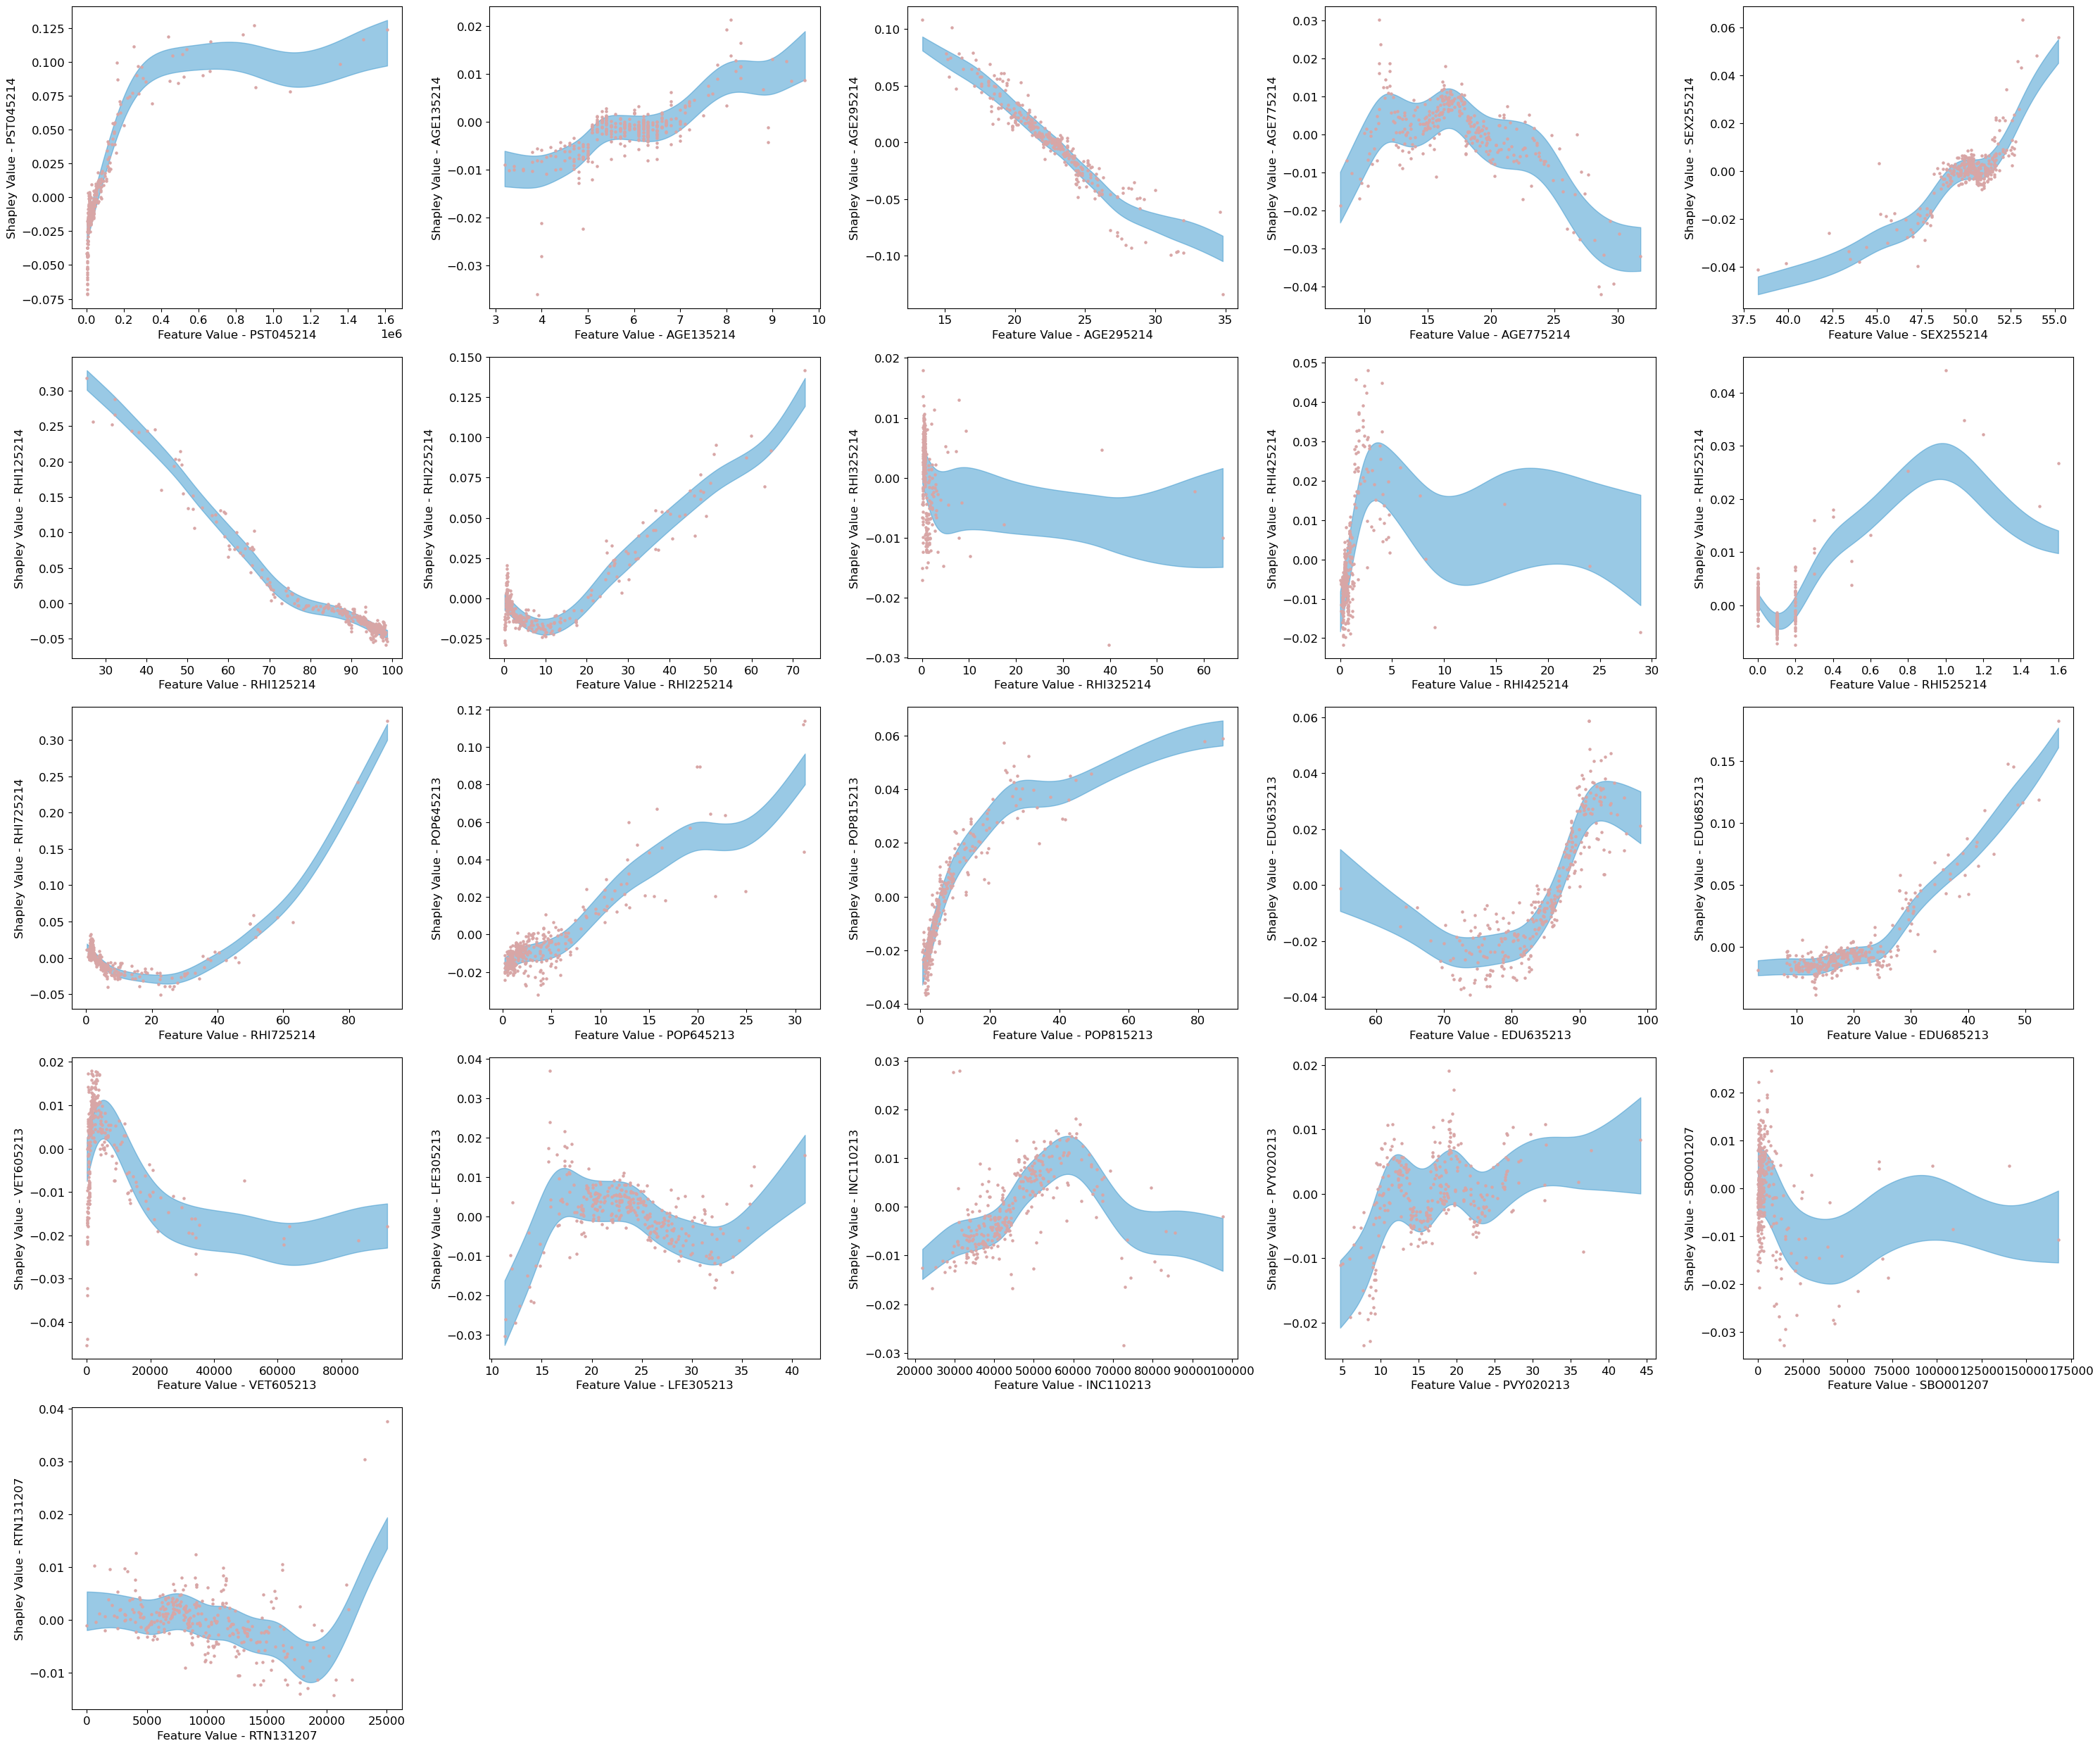

In [18]:
results.plot_partial_dependence_with_fitted_bounds()